### class별로 데이터 나누기

In [1]:
import os
import shutil

for i in range(5):
    os.makedirs('./train_video/{}'.format(i), exist_ok = True)
with open('./train.csv', 'r', encoding = 'utf-8-sig') as f:
    f = f.read()
train_info = f.split('\n')
del train_info[0]
del train_info[-1]
for info in train_info:
    info = info.split(',')
    file_name = '{}.mp4'.format(info[0])
    path = info[1]
    cls = info[2]
    shutil.copy(path, './train_video/{}/{}'.format(cls, file_name))

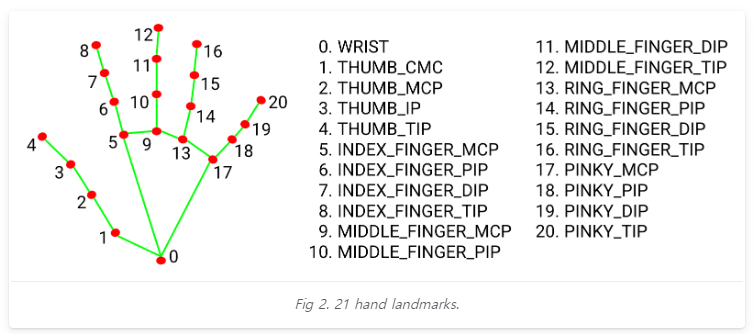

### MediaPipe로 LSTM데이터 추출

In [2]:
import cv2
import mediapipe as mp
from tqdm import tqdm
import random

def mp_to_lstm(video_path, interval):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands
    hands =  mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)
    xy_list_list = []
    cv2.destroyAllWindows()
    cap = cv2.VideoCapture(video_path)
    if cap.isOpened():
        cnt = 0
        while True:
            ret, img = cap.read()
            if cnt == interval and ret == True:
                cnt = 0
                xy_list = []
                results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if not results.multi_hand_landmarks: continue
                idx = 0
                for one_hand in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(img,one_hand,mp_hands.HAND_CONNECTIONS, 
                                              mp_drawing_styles.get_default_hand_landmarks_style(), 
                                              mp_drawing_styles.get_default_hand_connections_style())
                    for xy in one_hand.landmark:
                        xy_list.append(xy.x)
                        xy_list.append(xy.y)        
                xy_list_list.append(xy_list)
            elif ret == False: break
            cnt += 1
    cv2.destroyAllWindows()
    return xy_list_list

folder_list = os.listdir('./train_video')
dataset = []
for folder_name in folder_list:
    video_list = os.listdir('./train_video/{}'.format(folder_name))
    for video_name in tqdm(video_list):
        xy_list_list = mp_to_lstm('./train_video/{}/{}'.format(folder_name, video_name), 1)
        if len(xy_list_list) < 30 and len(xy_list_list) > 0:
            interval = 30 - len(xy_list_list)
            interval = interval / len(xy_list_list)
            full_list, cnt = [], 0
            for xy_list in xy_list_list:
                cnt += interval
                if cnt >= 1:
                    while True:
                        if cnt < 1: break
                        full_list.append(xy_list)
                        cnt -= 1
                full_list.append(xy_list)
        else:
            full_list = xy_list_list + []
        if len(full_list) > 29:
            while True:
                if len(full_list) == 29: break
                del full_list[-1]
        if len(full_list) == 29:
            dataset.append({'key': int(folder_name), 'value': full_list})
        else:
            print('file name: {} | frame ea: {}'.format(video_name, len(full_list)))
random.shuffle(dataset)
print(len(dataset))

 31%|█████████████████████████                                                        | 35/113 [00:41<01:20,  1.03s/it]

file name: TRAIN_211.mp4 | frame ea: 0


 14%|███████████▎                                                                     | 18/129 [00:20<02:01,  1.09s/it]

file name: TRAIN_074.mp4 | frame ea: 0


 22%|█████████████████▌                                                               | 28/129 [00:33<01:48,  1.08s/it]

file name: TRAIN_126.mp4 | frame ea: 0


 47%|██████████████████████████████████████▎                                          | 61/129 [01:12<01:03,  1.07it/s]

file name: TRAIN_278.mp4 | frame ea: 0


 53%|██████████████████████████████████████████▋                                      | 68/129 [01:21<01:01,  1.01s/it]

file name: TRAIN_312.mp4 | frame ea: 0


 40%|████████████████████████████████▏                                                | 48/121 [00:54<01:02,  1.17it/s]

file name: TRAIN_213.mp4 | frame ea: 0


 48%|██████████████████████████████████████▉                                          | 64/133 [01:11<01:09,  1.00s/it]

file name: TRAIN_284.mp4 | frame ea: 0


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [02:36<00:00,  1.38s/it]

603


In [3]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

현재 가상환경 GPU 사용 가능상태


In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list :
            self.y.append(dic['key'])
            self.X.append(dic['value'])
                
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))
        
    def __len__(self):
        return len(self.X)

In [6]:
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(dataset) * split_ratio[0])
val_len = int(len(dataset) * split_ratio[1])
test_len = len(dataset) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

482, 60, 61


In [7]:
from torch.utils.data import random_split
train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=8)
val_loader = DataLoader(valid_data, batch_size=8)
test_loader = DataLoader(test_data, batch_size=8)

In [7]:
class skeleton_LSTM(nn.Module) :
    def __init__(self):
        super(skeleton_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=42, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32,5)

    def forward(self, x) :
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:])
        return x

In [13]:
# 모델 초기화
import matplotlib.pyplot as plt
from torch.optim import Adam
def init_model():
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = skeleton_LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)
    
# epoch 카운터 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0
    
def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [14]:
import gc
from torch.cuda import memory_allocated, empty_cache
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
import numpy as np
def epoch(data_loader, mode = 'train'):
    global epoch_cnt
    
    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False
    
    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            net.eval()

        result = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출
        
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
        
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기르 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
            
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록
        
    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1
    
    clear_memory()
    
    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [15]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
    
def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

from IPython.display import clear_output
def print_log():
    # 학습 추이 출력
    
    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)
    
    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5} | V_Loss {:5} | V_acc. {:5} | \
🕒 {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)
    
    log_stack.append(log_str) # 프린트 준비
    
    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정
    
    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # 위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid() # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()
    
    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

In [16]:
# Training Initialization
init_model()
init_epoch()
init_log()
maximum_epoch = 100

# Training Iteration
import time
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

RuntimeError: Expected target size [8, 42], got [8]

In [12]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.9375
Test Loss: 0.3069


### Test 데이터 투입

In [13]:
import natsort
video_list = os.listdir('./test')
video_list = natsort.natsorted(video_list)
id_list, label_list = ['id'], ['label']
pred_class = 0
for video_name in tqdm(video_list):
    xy_list_list = mp_to_lstm('./test/{}'.format(video_name), 1)
    if len(xy_list_list) < 30 and len(xy_list_list) > 0:
        interval = 30 - len(xy_list_list)
        interval = interval / len(xy_list_list)
        full_list, cnt = [], 0
        for xy_list in xy_list_list:
            cnt += interval
            if cnt >= 1:
                while True:
                    if cnt < 1: break
                    full_list.append(xy_list)
                    cnt -= 1
            full_list.append(xy_list)
    else:
        full_list = xy_list_list + []
    if len(full_list) > 29:
        while True:
            if len(full_list) == 29: break
            del full_list[-1]
    if len(full_list) == 29:
        dataset = []
        dataset.append({'key': int(folder_name), 'value': full_list})
        dataset = MyDataset(dataset)
        dataset = DataLoader(dataset)
        for data, label in dataset:
            data = data.to(device)
            with torch.no_grad():
                result = net(data)
                _, out = torch.max(result, 1)
                pred_class = out.item()
            id_list.append(video_name.split('.')[0])
            label_list.append(pred_class)
    else:
        id_list.append(video_name.split('.')[0])
        label_list.append(pred_class)
        print('len: {} | file name: {}'.format(len(full_list), video_name))

  6%|██▌                                        | 9/153 [00:10<02:33,  1.07s/it]

len: 0 | file name: TEST_008.mp4


  8%|███▎                                      | 12/153 [00:14<02:21,  1.01s/it]

len: 0 | file name: TEST_011.mp4


 54%|██████████████████████▊                   | 83/153 [01:41<01:14,  1.06s/it]

len: 0 | file name: TEST_082.mp4


 95%|███████████████████████████████████████  | 146/153 [02:59<00:07,  1.11s/it]

len: 0 | file name: TEST_145.mp4


100%|█████████████████████████████████████████| 153/153 [03:09<00:00,  1.24s/it]


### 제출 csv 만들기

In [25]:
with open('./result.csv', 'w', encoding = 'utf-8-sig') as f:
    cnt = 0
    for i, j in zip(id_list, label_list):
        if cnt == len(id_list) - 1:
            f.write('{},{}'.format(i, j))
            print('csv 저장 완료')
        else:
            f.write('{},{}\n'.format(i, j))
        cnt += 1

csv 저장 완료


In [17]:
id_list

NameError: name 'id_list' is not defined